In [1]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph

Using TensorFlow backend.


In [2]:
data=pd.read_csv('C:\\Users\\user\\Desktop\\Clustering_Assignment\\movie_actor_network.csv', index_col=False, names=['movie','actor'])

In [3]:
edges = [tuple(x) for x in data.values.tolist()]

In [4]:
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')

In [5]:
A = list(nx.connected_component_subgraphs(B))[0]

In [6]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


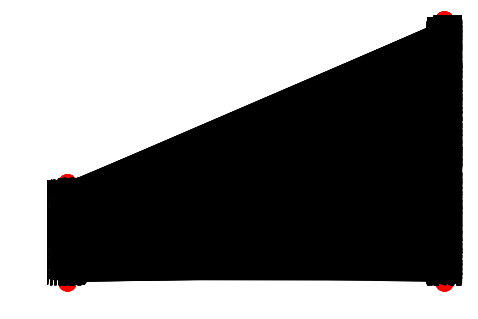

In [7]:
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))

nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [8]:
A_movies = []
A_actors = []
for i in A.nodes():
    if 'm' in i:
        A_movies.append(i)
    if 'a' in i:
        A_actors.append(i)
print('number of movies ', len(A_movies))
print('number of actors ', len(A_actors))

number of movies  1292
number of actors  3411


In [9]:

# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [10]:
from gensim.models import Word2Vec
model = Word2Vec(walks, size=128, window=5)
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [11]:
actors_vector=[]
movies_vector=[]
actors_node_id=[]
movies_node_id=[]
for i in range(len(model.wv.index2word)):
    if 'a' in model.wv.index2word[i]:
        actors_vector.append(model.wv.vectors[i])
        actors_node_id.append(model.wv.index2word[i])
    if 'm' in model.wv.index2word[i]:
        movies_vector.append(model.wv.vectors[i])   
        movies_node_id.append(model.wv.index2word[i])

<h3> Clustering Algorithm to group similar actors<h3>

In [19]:
#considering Actor nodes:
nodes_actor_dim=model.wv.vectors[len(A_movies):]
from sklearn.cluster import KMeans#Applying K-means Cluster Algo
nodes_actor=list(A.nodes)[len(A_movies):]
clusters=[1,3,5,7,9]
ego_edges_cluster_set=[]
cluster_set=[]
C = nx.Graph()
for j in range(len(clusters)):
    ego_edges_cluster_set=[]
    kmeans = KMeans(n_clusters=clusters[j], random_state=0).fit(actors_vector)
    cluster_pred=kmeans.predict(actors_vector)#predicting cluster for each actor
    for k in range(clusters[j]):
        ego_edges_cluster=[]
        for i in range(len(cluster_pred)):
            #print(actors_vector[i])
            #C.add_node(actors_node_id[i],label=str(cluster_pred[i]))
            if cluster_pred[i]==k:
                C.add_node(actors_node_id[i],label=str(cluster_pred[i]))
                C=nx.ego_graph(B, nodes_actor[i])
                l=list(C.edges())
                for i in l : 
                    ego_edges_cluster.append(i)
        ego_edges_cluster_set.append(ego_edges_cluster)           
    #print(len(ego_edges_cluster_set))
    largest_cc=[]
    no_actors_movies=[]
    no_total_nodes=[]
    no_actors=[]
    no_movies=[]
    for m in range(len(ego_edges_cluster_set)):
        cluster_set=nx.Graph()
        cluster_set.add_edges_from(ego_edges_cluster_set[m], label='m')
        
        largest_cc.append(len(max(nx.connected_components(cluster_set), key=len)))
        movies = []
        actors = []
        for i in cluster_set.nodes():
            if 'm' in i:
                movies.append(i)
            if 'a' in i:
                actors.append(i)
        no_actors_movies.append([len(actors),len(movies),])
        no_actors.append(len(actors))
        no_movies.append(len(movies))
        no_total_nodes.append(len(list(cluster_set.nodes())))
    print('largest connected component:',largest_cc)
    print('no_actors_movies:',no_actors_movies)
    print('no_total_nodes:',no_total_nodes)
    print(no_movies)
    print(no_actors)
    Cost1=0
    Cost3=0
    for p in range(len(ego_edges_cluster_set)):
        Cost1=Cost1+(largest_cc[p]/no_total_nodes[p])
        Cost3=Cost3+(len(ego_edges_cluster_set[p])/(no_movies[p]))
    Cost1=Cost1/(len(ego_edges_cluster_set))
    Cost3=Cost3/(len(ego_edges_cluster_set))
    print('Cost1:',Cost1)
    Cost2=0
    Cost2=(max(no_actors)/len(A_actors))
    Cost2=Cost2*(1-Cost2)
    print('Cost2:',Cost2)
    print('Cost3:',Cost3)
    print('\nThe final Multiple:',Cost1*Cost2*Cost3)

largest connected component: [4703]
no_actors_movies: [[3411, 1292]]
no_total_nodes: [4703]
[1292]
[3411]
Cost1: 1.0
Cost2: 0.0
Cost3: 7.469040247678018

The final Multiple: 0.0
largest connected component: [4124, 209, 818]
no_actors_movies: [[2969, 1256], [67, 221], [375, 667]]
no_total_nodes: [4225, 288, 1042]
[1256, 221, 667]
[2969, 67, 375]
Cost1: 0.8289393032625352
Cost2: 0.11278959264098139
Cost3: 3.2108585463587196

The final Multiple: 0.30020155196385195
largest connected component: [189, 703, 1173, 26, 3640]
no_actors_movies: [[37, 194], [316, 620], [356, 940], [32, 42], [2670, 1177]]
no_total_nodes: [231, 936, 1296, 74, 3847]
[194, 620, 940, 42, 1177]
[37, 316, 356, 32, 2670]
Cost1: 0.7543771951979646
Cost2: 0.1700458473246187
Cost3: 2.411374541556559

The final Multiple: 0.3093280139739721
largest connected component: [91, 354, 607, 190, 602, 26, 3760]
no_actors_movies: [[66, 189], [133, 449], [250, 585], [39, 195], [214, 562], [30, 42], [2679, 1211]]
no_total_nodes: [255, 5

In [31]:
Actor_C = nx.Graph()
kmeans = KMeans(n_clusters=7, random_state=0).fit(actors_vector)
cluster_pred=kmeans.predict(actors_vector)
for i in range(len(cluster_pred)):
    for k in range(7):
        if cluster_pred[i]==k:
            Actor_C.add_node(actors_node_id[i],label=str(k))
print("Actor nodes:",len(list(Actor_C.nodes())))

Actor nodes: 3411


BY Observation the optimum cluster number for Actors vectors is 7

<h3>Applying TSNE for Actor Nodes<h3>

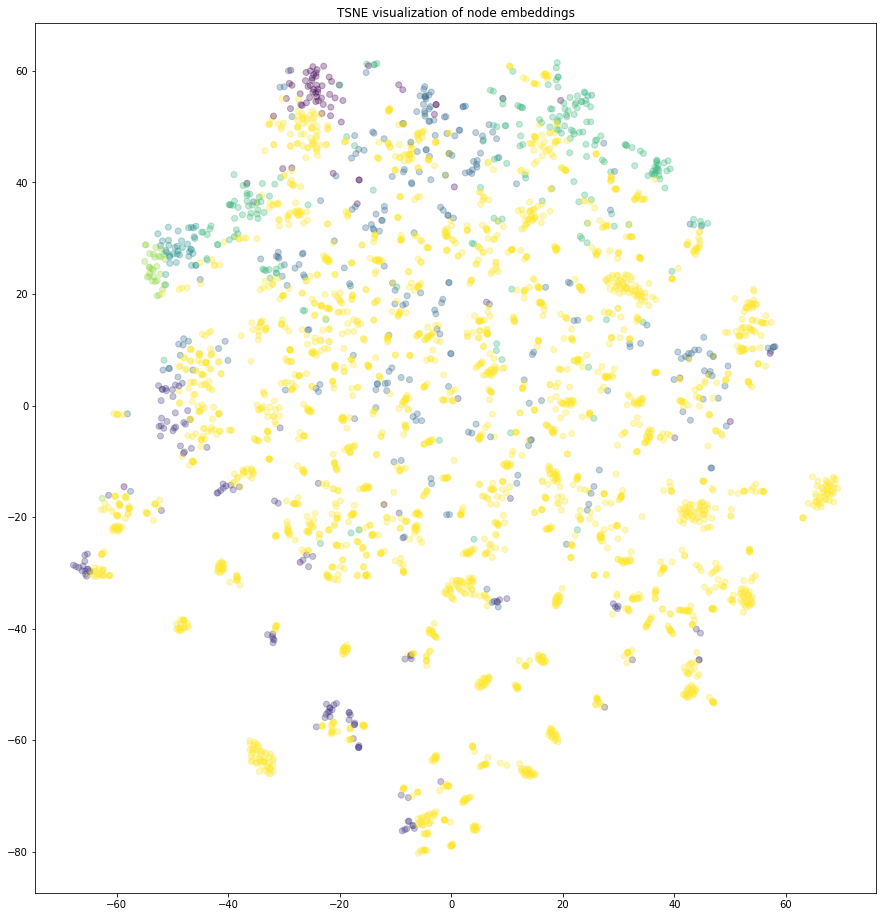

In [32]:
# Retrieve node embeddings and corresponding subjects
node_ids = actors_node_id  # list of node IDs
node_embeddings = actors_vector  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ Actor_C.node[node_id]['label'] for node_id in node_ids]

from sklearn.manifold import TSNE
transform = TSNE #PCA
trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

import numpy as np
# draw the points

label_map = { l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [ label_map[target] for target in node_targets]

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=node_colours, alpha=0.3)
plt.title('{} visualization of node embeddings'.format(transform.__name__))

plt.show()

<h3> Clustering Algorithm to group similar movies<h3>

In [25]:
#considering Movie nodes:
from sklearn.cluster import KMeans#Applying K-means Cluster Algo
nodes_movies=list(A.nodes)[0:len(A_movies)]
clusters=[1,2,5,7,10,15,20,30]
ego_edges_cluster_set=[]
cluster_set=[]
for j in range(len(clusters)):
    ego_edges_cluster_set=[]
    kmeans = KMeans(n_clusters=clusters[j], random_state=0).fit(movies_vector)
    cluster_pred=kmeans.predict(movies_vector)#predicting cluster for each actor
    for k in range(clusters[j]):
        ego_edges_cluster=[]
        for i in range(len(cluster_pred)):
            
            if cluster_pred[i]==k:
                C=nx.ego_graph(B, nodes_movies[i])
                l=list(C.edges())
                for i in l : 
                    ego_edges_cluster.append(i)
        ego_edges_cluster_set.append(ego_edges_cluster)           
    #print(len(ego_edges_cluster_set))
    largest_cc=[]
    no_actors_movies=[]
    no_total_nodes=[]
    no_actors=[]
    no_movies=[]
    for m in range(len(ego_edges_cluster_set)):
        cluster_set=nx.Graph()
        cluster_set.add_edges_from(ego_edges_cluster_set[m], label='acted')
        largest_cc.append(len(max(nx.connected_components(cluster_set), key=len)))
        movies = []
        actors = []
        for i in cluster_set.nodes():
            if 'm' in i:
                movies.append(i)
            if 'a' in i:
                actors.append(i)
        no_actors_movies.append([len(actors),len(movies),])
        no_actors.append(len(actors))
        no_movies.append(len(movies))
        no_total_nodes.append(len(list(cluster_set.nodes())))
    print('largest connected component:',largest_cc)
    print('no_actors_movies:',no_actors_movies)
    print('no_total_nodes:',no_total_nodes)
    print(no_movies)
    print(no_actors)
    Cost1=0
    Cost3=0
    for p in range(len(ego_edges_cluster_set)):
        Cost1=Cost1+(largest_cc[p]/no_total_nodes[p])
        Cost3=Cost3+(len(ego_edges_cluster_set[p])/(no_actors[p]))
    Cost1=Cost1/(len(ego_edges_cluster_set))
    Cost3=Cost3/(len(ego_edges_cluster_set))
    print('Cost1:',Cost1)
    Cost2=0
    Cost2=(max(no_movies)/len(A_movies))
    Cost2=Cost2*(1-Cost2)
    print('Cost2:',Cost2)
    print('Cost3:',Cost3)
    print('\nThe final Multiple:',Cost1*Cost2*Cost3)

largest connected component: [4703]
no_actors_movies: [[3411, 1292]]
no_total_nodes: [4703]
[1292]
[3411]
Cost1: 1.0
Cost2: 0.0
Cost3: 2.829082380533568

The final Multiple: 0.0
largest connected component: [3079, 2179]
no_actors_movies: [[2382, 828], [1733, 464]]
no_total_nodes: [3210, 2197]
[828, 464]
[2382, 1733]
Cost1: 0.9754985203555684
Cost2: 0.23015652407288484
Cost3: 2.300505740543982

The final Multiple: 0.5165034494976003
largest connected component: [61, 1090, 2329, 761, 1272]
no_actors_movies: [[177, 30], [898, 244], [1851, 532], [767, 170], [1142, 316]]
no_total_nodes: [207, 1142, 2383, 937, 1458]
[30, 244, 532, 170, 316]
[177, 898, 1851, 767, 1142]
Cost1: 0.7822171600197215
Cost2: 0.2422145328719723
Cost3: 1.79265135522759

The final Multiple: 0.3396435489253084
largest connected component: [1326, 61, 724, 1538, 317, 645, 1102]
no_actors_movies: [[1089, 295], [184, 30], [644, 159], [1240, 303], [352, 91], [658, 139], [1015, 275]]
no_total_nodes: [1384, 214, 803, 1543, 443

BY Observation the optimum cluster number for movie vectors is 2

In [33]:
Movie_C = nx.Graph()
kmeans = KMeans(n_clusters=2, random_state=0).fit(movies_vector)
cluster_pred=kmeans.predict(movies_vector)
for i in range(len(cluster_pred)):
    for k in range(7):
        if cluster_pred[i]==k:
            Movie_C.add_node(movies_node_id[i],label=str(k))
print(len(list(Movie_C.nodes())))

1292


<h3>Applying TSNE for Movie Nodes<h3>

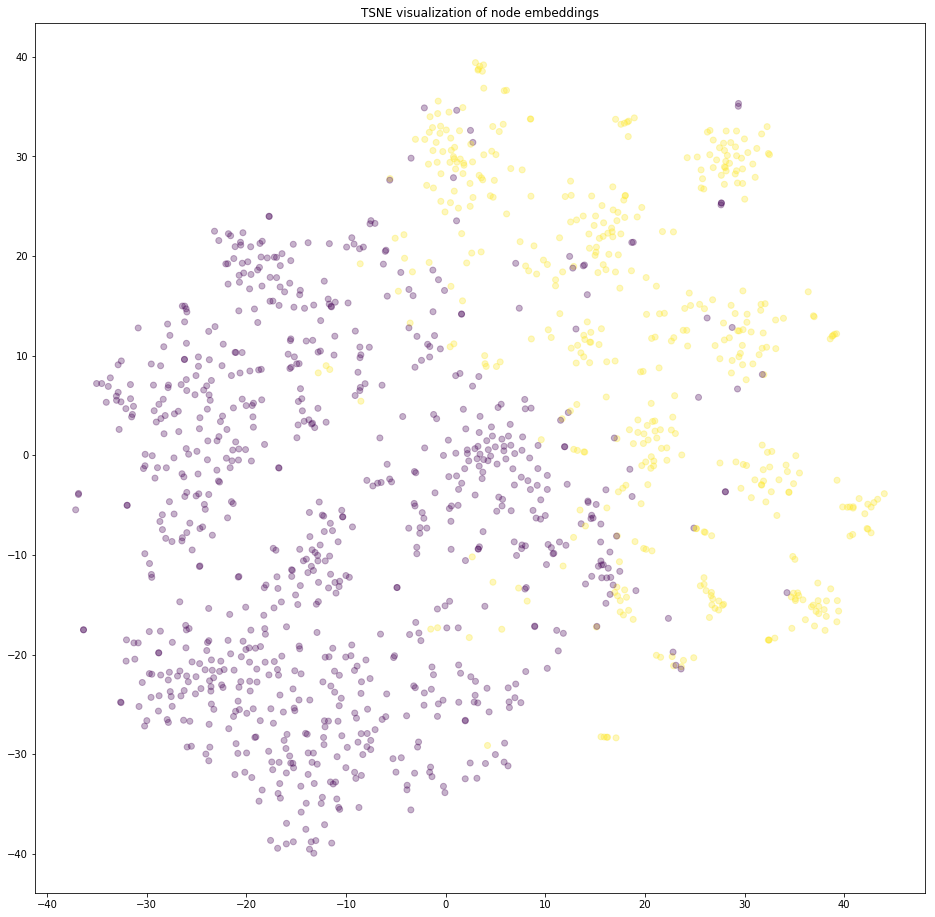

In [34]:
# Retrieve node embeddings and corresponding subjects
node_ids = movies_node_id  # list of node IDs
node_embeddings = movies_vector  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ Movie_C.node[node_id]['label'] for node_id in node_ids]

from sklearn.manifold import TSNE
transform = TSNE #PCA
trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

import numpy as np
# draw the points

label_map = { l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [ label_map[target] for target in node_targets]

plt.figure(figsize=(20,16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=node_colours, alpha=0.3)
plt.title('{} visualization of node embeddings'.format(transform.__name__))

plt.show()